In [381]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import math
from collections import Counter

import os

In [382]:
path = os.getcwd()
path

'/Users/tamannaurmi/Documents/NEU_classes/sem3_math7241_proba'

In [386]:
def get_key(val, my_dict):
    for key, value in my_dict.items():
        if val == value:
            return key



def jumps(df, col):
    
    plt.figure(figsize = (10, 3))
    plt.plot(df['steps'][0:1000], df[col][0:1000])
    plt.xlabel('time')
    plt.ylabel('state')
    plt.title('Timeseries')
    
    dt = df[col].values
    n1 = dt[0]
    dt_jumps = [] # edges
    source = []
    for elem in dt[1:]:
        jump = (n1, elem)
        dt_jumps.append(jump)
        source.append(n1)
        n1 = elem

    dt_edge_counter = Counter(i for i in dt_jumps)
    dt_edge_freq = pd.DataFrame.from_dict(dt_edge_counter, orient='index').reset_index()
    dt_edge_freq.columns = ['jump', 'count']
    
    dt_freq = pd.DataFrame(df[col].value_counts()).reset_index()
    dt_freq['prob'] = dt_freq[col]/sum(dt_freq[col])
    dt_freq.columns = ['state', 'frequency', 'probability']
    dt_freq = dt_freq.sort_values(by = ['state'])
    
    dt_f_dict = dict(zip(dt_freq['state'].values, dt_freq['frequency'].values))
    dt_edge_freq['transition_prob'] = dt_edge_freq.apply(lambda row: row['count']/dt_f_dict.get(row['jump'][0]), axis = 1)
    
    plt.figure(figsize = (8,5))
    plt.plot(dt_freq['state'], dt_freq['probability'], marker = '.')
    plt.title('Probability distribution of states')
    plt.xlabel('states')
    plt.ylabel('probability')
    plt.show()
    
    TM = np.zeros((9, 9))
    for index, row in dt_edge_freq.iterrows():
        # print(row.jump[0], row.jump[1], row.transition_prob)
        TM[row.jump[0]-1][row.jump[1]-1] = row.transition_prob

    TM_2 = np.matmul(TM, TM)

    plt.figure(figsize = (9, 8))
    ax = sns.heatmap(TM, annot= True, linewidth = 0.5)
    ax.xaxis.tick_top()
    ax.set_title('$T$')
    
    plt.figure(figsize = (9, 8))
    ax = sns.heatmap(TM_2, annot= True, linewidth = 0.5)
    ax.xaxis.tick_top()
    ax.set_title('$T^2$')
    
    plt.figure(figsize = (10, 6))
    for r in range(len(TM)):
        plt.plot(TM[r], marker = 'o', label = 'Source: ' + str(r), alpha = 0.6)
    plt.title('Transitions from state to state')   
    plt.legend()

    return TM, TM_2, dt_freq, dt_edge_freq

def two_jumps(df, col):
    
    dt = df[col].values
    ln = len(dt)

    dt_jumps = [] # edges
    for i in range(ln-2):
        jump = (dt[i], dt[i+2])
        dt_jumps.append(jump)

    dt_edge_counter = Counter(i for i in dt_jumps)
    dt_edge_freq = pd.DataFrame.from_dict(dt_edge_counter, orient='index').reset_index()
    dt_edge_freq.columns = ['jump', 'count']

    dt_freq = pd.DataFrame(df[col].value_counts()).reset_index()
    dt_freq['prob'] = dt_freq[col]/sum(dt_freq[col])
    dt_freq.columns = ['state', 'frequency', 'probability']
    dt_freq = dt_freq.sort_values(by = ['state'])

    dt_f_dict = dict(zip(dt_freq['state'].values, dt_freq['frequency'].values))
    dt_edge_freq['transition_prob'] = dt_edge_freq.apply(lambda row: row['count']/dt_f_dict.get(row['jump'][0]), axis = 1)

    return dt_freq, dt_edge_freq 


    

In [387]:
## Source: https://data.world/data-society/city-of-baltimore-crime-data/workspace/file?filename=BPD_Part_1_Victim_Based_Crime_Data.csv

data_crime = pd.read_csv(path + '/BPD_Part_1_Victim_Based_Crime_Data.csv')

CrimeCode_pooled = {'4B':'AA','4D':'AA','4C':'AA','4E':'CA','1K':'HC','3AF':'RS','9S':'ST','4A':'AA','2A':'RP','3CK':'RC','1F':'HC','3JF':'RR','3CF':'RC',
 '3AK':'RS','3GF':'RC','3NF':'RS','3AJF':'RCa','1O':'HC','3AO':'RS','3JO':'RR','3EK':'RC','3AJK':'RCa','3EF':'RC','3GK':'RC','3JK':'RR',
 '3CO':'RC','3LF':'RC','3AJO':'RCa','3NK':'RS','3LO':'RC','3GO':'RC','3NO':'RS','3EO':'RC','3LK':'RC'}
data_crime['CrimeCode_new'] = data_crime.apply(lambda row: CrimeCode_pooled.get(row.CrimeCode), axis = 1)
dt = data_crime[['CrimeDate', 'CrimeTime', 'CrimeCode', 'CrimeCode_new', 'Neighborhood']]
print(dt.shape)
dt = dt.dropna()
print(dt.shape)

cc_dict = pd.DataFrame(data_crime["CrimeCode_new"].drop_duplicates().reset_index().drop(['index'], axis = 1)).to_dict().get('CrimeCode_new')
nh_dict = pd.DataFrame(data_crime["Neighborhood"].drop_duplicates().reset_index().drop(['index'], axis = 1)).to_dict().get('Neighborhood')


dt["CrimeCode_cat"] = dt.apply(lambda row: get_key(row["CrimeCode_new"], cc_dict), axis = 1)
dt["Neighborhood_cat"] = dt.apply(lambda row: get_key(row["Neighborhood"], nh_dict), axis = 1)

dt = dt.sort_values(by = ['CrimeDate', 'CrimeTime']).reset_index().drop(['index'], axis = 1).reset_index()
dt = dt.rename(columns = {'index':'steps'})
dt_crime = dt.copy()

(285807, 5)
(96941, 5)


In [388]:
dt_crime

,steps,CrimeDate,CrimeTime,CrimeCode,CrimeCode_new,Neighborhood,CrimeCode_cat,Neighborhood_cat
0,0,01/01/2011,00:05:00,4B,AA,Frankford,3,7
1,1,01/01/2011,00:15:00,4D,AA,Inner Harbor,3,40
2,2,01/01/2011,00:20:00,4C,AA,Windsor Hills,3,49
3,3,01/01/2011,00:30:00,4E,CA,Inner Harbor,2,40
4,4,01/01/2011,00:39:00,4E,CA,Remington,2,21
...,...,...,...,...,...,...,...,...
96936,96936,12/31/2015,20:25:00,4E,CA,Hamilton Hills,2,4
96937,96937,12/31/2015,20:30:00,4E,CA,Charles North,2,106
96938,96938,12/31/2015,22:15:00,4E,CA,Bayview,2,185
96939,96939,12/31/2015,23:20:00,4E,CA,Hampden,2,169


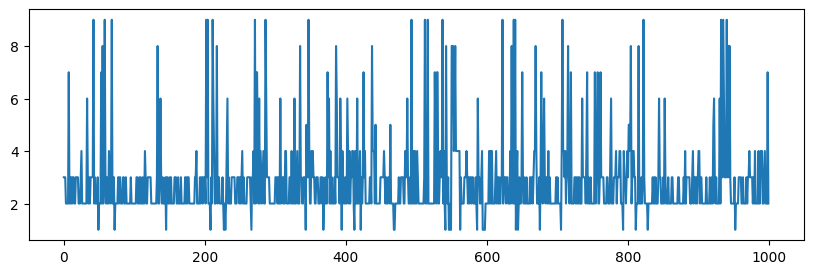

In [27]:
plt.figure(figsize = (10, 3))
plt.plot(dt['steps'][0:1000], dt['CrimeCode_cat'][0:1000])

In [380]:
dt_crime

,steps,CrimeDate,CrimeTime,CrimeCode,CrimeCode_new,Neighborhood,CrimeCode_cat,Neighborhood_cat
0,0,01/01/2011,00:05:00,4B,AA,Frankford,key doesn't exist,key doesn't exist
1,1,01/01/2011,00:15:00,4D,AA,Inner Harbor,key doesn't exist,key doesn't exist
2,2,01/01/2011,00:20:00,4C,AA,Windsor Hills,key doesn't exist,key doesn't exist
3,3,01/01/2011,00:30:00,4E,CA,Inner Harbor,key doesn't exist,key doesn't exist
4,4,01/01/2011,00:39:00,4E,CA,Remington,key doesn't exist,key doesn't exist
...,...,...,...,...,...,...,...,...
96936,96936,12/31/2015,20:25:00,4E,CA,Hamilton Hills,key doesn't exist,key doesn't exist
96937,96937,12/31/2015,20:30:00,4E,CA,Charles North,key doesn't exist,key doesn't exist
96938,96938,12/31/2015,22:15:00,4E,CA,Bayview,key doesn't exist,key doesn't exist
96939,96939,12/31/2015,23:20:00,4E,CA,Hampden,key doesn't exist,key doesn't exist


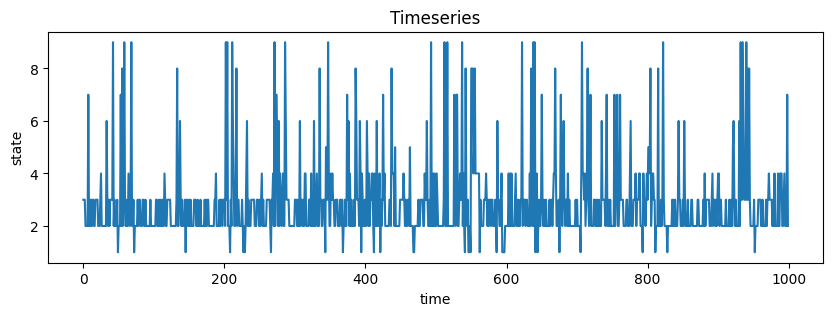

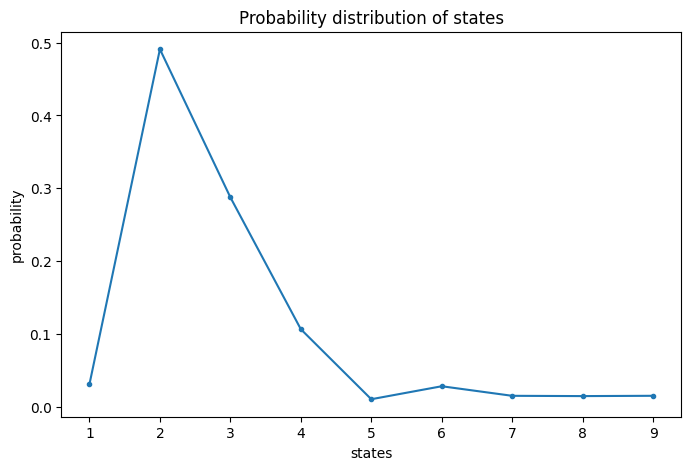

array([[0.12922465, 0.44168323, 0.24618953, 0.10636183, 0.01060305,
        0.02186879, 0.01822399, 0.01259112, 0.01325381],
       [0.02770013, 0.55051386, 0.26197432, 0.08955255, 0.00926841,
        0.02118493, 0.01345075, 0.01013009, 0.01620395],
       [0.02765721, 0.45363561, 0.35122144, 0.09186785, 0.01065394,
        0.02507443, 0.01226818, 0.01219643, 0.0154249 ],
       [0.03271073, 0.41507791, 0.2402013 , 0.23236233, 0.01316171,
        0.02487177, 0.01625859, 0.01248427, 0.01287138],
       [0.03543307, 0.42224409, 0.29035433, 0.14370079, 0.04429134,
        0.0246063 , 0.01279528, 0.01082677, 0.01574803],
       [0.01750547, 0.28628738, 0.36579139, 0.08679796, 0.00948213,
        0.17104303, 0.05032823, 0.00692925, 0.00583516],
       [0.0244898 , 0.43333333, 0.26122449, 0.09931973, 0.00680272,
        0.10340136, 0.05442177, 0.00884354, 0.00816327],
       [0.02234637, 0.3547486 , 0.23184358, 0.07681564, 0.00837989,
        0.01675978, 0.01326816, 0.2674581 , 0.00837989],


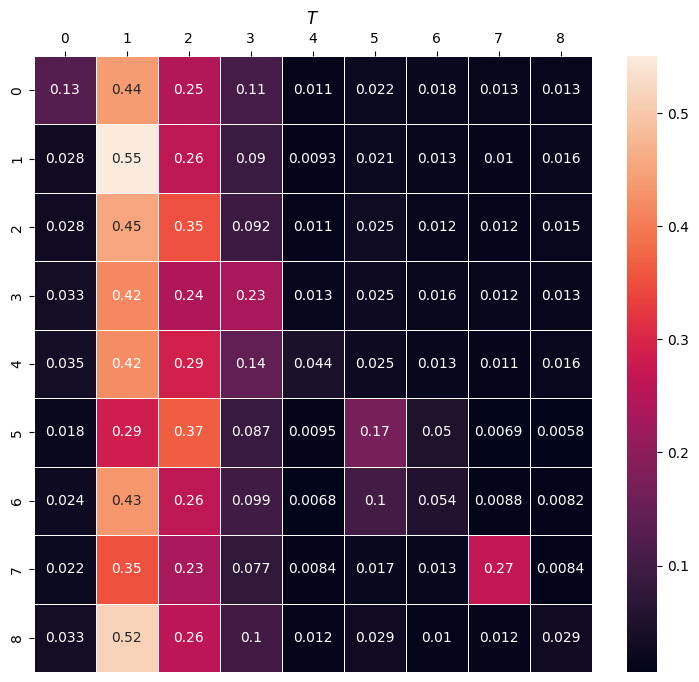

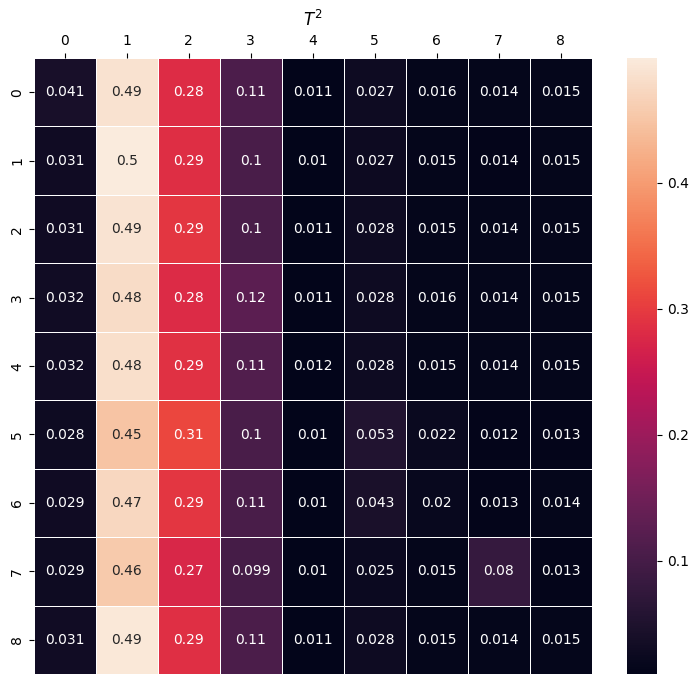

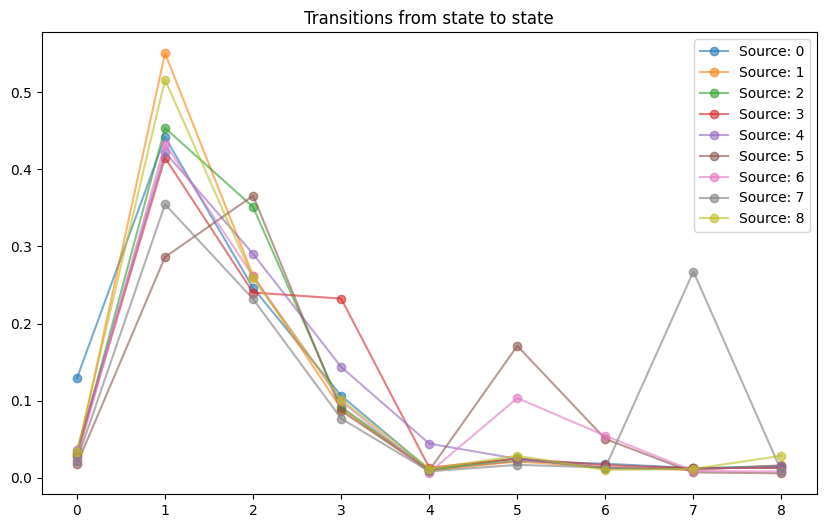

In [389]:
TM_obs, TM2_obs, cc_freq_obs, cc_edge_freq_obs = jumps(dt_crime, 'CrimeCode_cat')

TM_obs

[0.03081323, 0.4857931 , 0.28460779, 0.10549808, 0.01037316, 0.02799532, 0.01500845, 0.01462047, 0.01502883]

In [309]:


cc_freq2, cc_edge_freq2 = two_jumps(dt_crime, 'CrimeCode_cat')



In [299]:
dt[-12:-1]

array([3, 2, 2, 3, 2, 7, 4, 2, 2, 2, 2])

In [240]:
## Simulated time-series

import random
cc_sim = [3]
N = 96941

for step in range(N):
    pos = 0
    row = TM_2[cc_sim[-1]-1]
#     print(row)
    a = list(np.random.multinomial(1, row, size=1)[0])
    new_state = a.index(1)
    cc_sim.append(new_state+1)


cc_sim_df = pd.DataFrame(cc_sim)
cc_sim_df['steps'] = np.array(range(len(cc_sim)))
cc_sim_df.columns = ['state', 'steps']
cc_sim_df = cc_sim_df[['steps', 'state']]
cc_sim_df



,steps,state
0,0,3
1,1,2
2,2,6
3,3,4
4,4,3
...,...,...
96937,96937,3
96938,96938,2
96939,96939,2
96940,96940,3


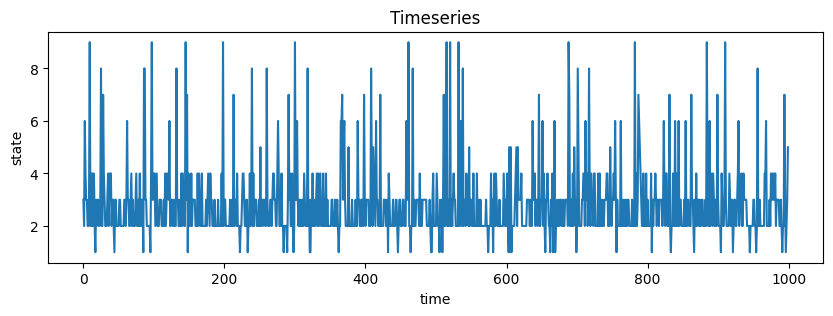

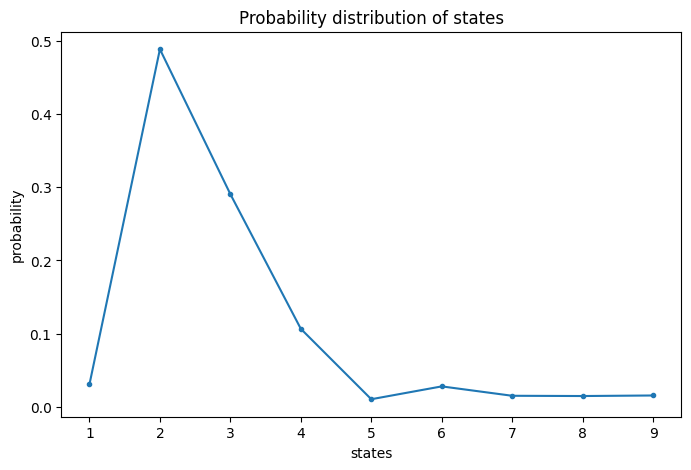

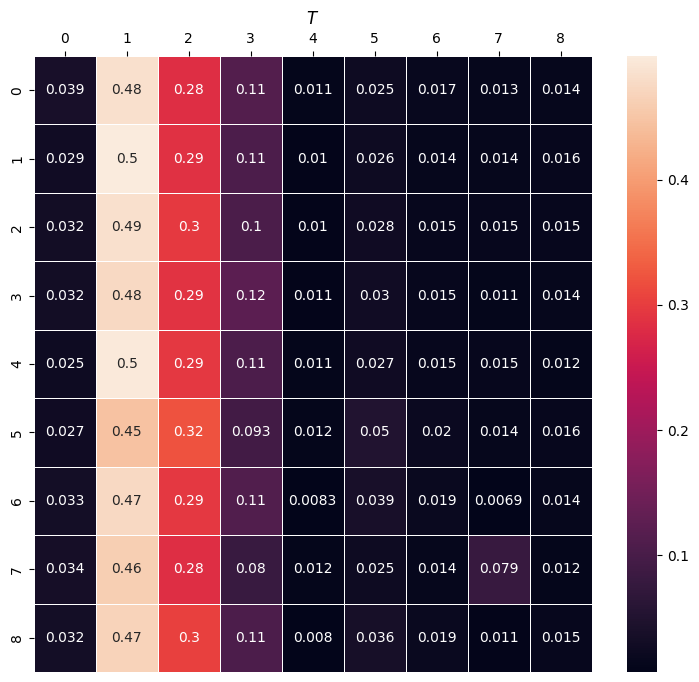

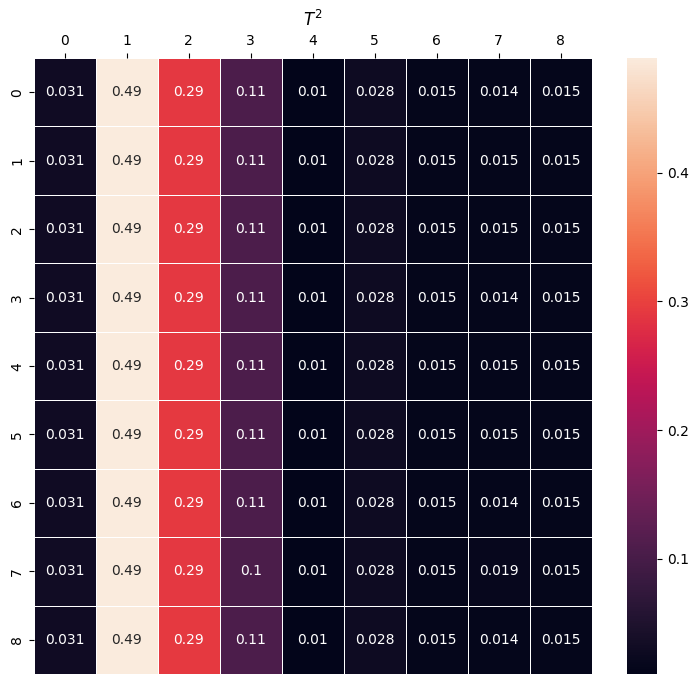

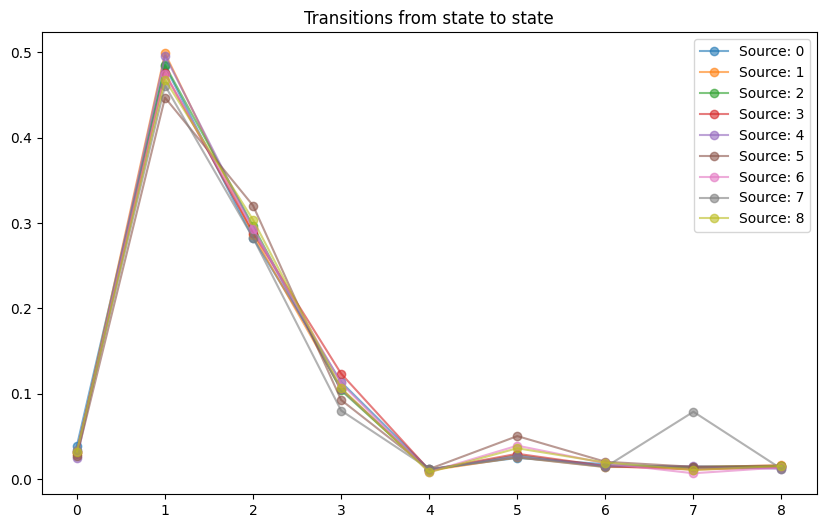

In [242]:
TM_sim, TM2_sim, cc_freq_sim, cc_edge_freq_sim = jumps(cc_sim_df, 'state')

In [411]:
cc_freq2, cc_edge_freq2 = two_jumps(dt_crime, 'CrimeCode_cat')
cc_edge_freq2

,jump,count,transition_prob
0,"(3, 3)",8499,0.304875
1,"(3, 2)",13405,0.480862
2,"(2, 2)",24818,0.521595
3,"(2, 7)",708,0.014880
4,"(7, 3)",423,0.287755
...,...,...,...
76,"(7, 9)",23,0.015646
77,"(7, 7)",28,0.019048
78,"(6, 7)",39,0.014223
79,"(7, 5)",14,0.009524


In [435]:
a = np.matmul(TM_ori, TM_ori)
for i in range(1000):
    a = np.matmul(a, TM_ori)
a

array([[0.03081291, 0.48578809, 0.28460486, 0.10549699, 0.01037305,
        0.02799503, 0.01500829, 0.01462032, 0.01502867],
       [0.03081218, 0.48577662, 0.28459813, 0.1054945 , 0.01037281,
        0.02799437, 0.01500794, 0.01461998, 0.01502832],
       [0.0308129 , 0.48578794, 0.28460476, 0.10549696, 0.01037305,
        0.02799503, 0.01500829, 0.01462032, 0.01502867],
       [0.03081293, 0.48578845, 0.28460507, 0.10549707, 0.01037306,
        0.02799505, 0.0150083 , 0.01462033, 0.01502868],
       [0.03081293, 0.48578833, 0.284605  , 0.10549705, 0.01037306,
        0.02799505, 0.0150083 , 0.01462033, 0.01502868],
       [0.03081304, 0.48579017, 0.28460607, 0.10549744, 0.0103731 ,
        0.02799515, 0.01500836, 0.01462039, 0.01502874],
       [0.03081293, 0.48578836, 0.28460501, 0.10549705, 0.01037306,
        0.02799505, 0.0150083 , 0.01462033, 0.01502868],
       [0.030813  , 0.48578941, 0.28460563, 0.10549728, 0.01037308,
        0.02799511, 0.01500833, 0.01462036, 0.01502871],


In [413]:
TM2_ori

array([[0.04114917, 0.48600246, 0.28172699, 0.10817043, 0.01054621,
        0.02747646, 0.01557574, 0.01438002, 0.01496323],
       [0.03079809, 0.49907933, 0.28505835, 0.10404678, 0.01034073,
        0.02693909, 0.01479591, 0.01350129, 0.01540783],
       [0.03076153, 0.48869117, 0.29336336, 0.10460257, 0.0105222 ,
        0.02777069, 0.01479319, 0.01421192, 0.01527383],
       [0.03197615, 0.4791639 , 0.28036287, 0.12463632, 0.01099398,
        0.02814657, 0.01550573, 0.01439341, 0.01481234],
       [0.03208563, 0.48272591, 0.28762574, 0.11384367, 0.01182868,
        0.02782707, 0.0150293 , 0.01389957, 0.01512555],
       [0.02806011, 0.44755195, 0.3102154 , 0.10360301, 0.01038822,
        0.0527543 , 0.02168858, 0.01231911, 0.0134133 ],
       [0.02949491, 0.47250854, 0.29333376, 0.10535055, 0.01018663,
        0.0425979 , 0.01954781, 0.01285498, 0.01411582],
       [0.02881004, 0.45551398, 0.27452322, 0.09866338, 0.00996435,
        0.02489432, 0.01457894, 0.07961647, 0.01342783],


In [416]:
obs_2step = cc_edge_freq2
obs_freq2_mat = np.zeros((9, 9))

for index, row in cc_edge_freq.iterrows():
    # print(row.jump[0], row.jump[1], row.transition_prob)
    obs_freq2_mat[row.jump[0]-1][row.jump[1]-1] = row['count']
    
obs_freq2_mat


array([[3.9000e+02, 1.3330e+03, 7.4300e+02, 3.2100e+02, 3.2000e+01,
        6.6000e+01, 5.5000e+01, 3.8000e+01, 4.0000e+01],
       [1.3180e+03, 2.6194e+04, 1.2465e+04, 4.2610e+03, 4.4100e+02,
        1.0080e+03, 6.4000e+02, 4.8200e+02, 7.7100e+02],
       [7.7100e+02, 1.2646e+04, 9.7910e+03, 2.5610e+03, 2.9700e+02,
        6.9900e+02, 3.4200e+02, 3.4000e+02, 4.3000e+02],
       [3.3800e+02, 4.2890e+03, 2.4820e+03, 2.4010e+03, 1.3600e+02,
        2.5700e+02, 1.6800e+02, 1.2900e+02, 1.3300e+02],
       [3.6000e+01, 4.2900e+02, 2.9500e+02, 1.4600e+02, 4.5000e+01,
        2.5000e+01, 1.3000e+01, 1.1000e+01, 1.6000e+01],
       [4.8000e+01, 7.8500e+02, 1.0030e+03, 2.3800e+02, 2.6000e+01,
        4.6900e+02, 1.3800e+02, 1.9000e+01, 1.6000e+01],
       [3.6000e+01, 6.3700e+02, 3.8400e+02, 1.4600e+02, 1.0000e+01,
        1.5200e+02, 8.0000e+01, 1.3000e+01, 1.2000e+01],
       [3.2000e+01, 5.0800e+02, 3.3200e+02, 1.1000e+02, 1.2000e+01,
        2.4000e+01, 1.9000e+01, 3.8300e+02, 1.2000e+01],


In [419]:
exp_T2 = []
for row in range(len(TM2_ori)):
    deg = sum(obs_freq2_mat[row])
    print(deg, cc_freq2.frequency[row])
    exp_T2.append(TM2_ori[row]*deg)
    
exp_T2 = np.array(exp_T2)
display(exp_T2)

exp_edge = []
exp_freq = []
for i in range(len(exp_T2)):
    for j in range(len(exp_T2)):
        exp_edge.append((i+1, j+1))
        exp_freq.append(exp_T2[i][j])
    
exp_2step = pd.DataFrame.from_dict(dict(zip(exp_edge, exp_freq)), orient='index').reset_index()
exp_2step.columns = ['jump', 'count']
exp_2step

3018.0 47581
47580.0 27877
27877.0 10333
10333.0 3018
1016.0 2742
2742.0 1472
1470.0 1470
1432.0 1432
1472.0 1016


array([[1.24188184e+02, 1.46675544e+03, 8.50252060e+02, 3.26458369e+02,
        3.18284496e+01, 8.29239697e+01, 4.70075729e+01, 4.33989006e+01,
        4.51590407e+01],
       [1.46537310e+03, 2.37461945e+04, 1.35630763e+04, 4.95054599e+03,
        4.92012097e+02, 1.28176201e+03, 7.03989391e+02, 6.42391489e+02,
        7.33104627e+02],
       [8.57539075e+02, 1.36232436e+04, 8.17809052e+03, 2.91600597e+03,
        2.93327386e+02, 7.74163569e+02, 4.12389662e+02, 3.96185808e+02,
        4.25788591e+02],
       [3.30409541e+02, 4.95120063e+03, 2.89698953e+03, 1.28786711e+03,
        1.13600786e+02, 2.90838460e+02, 1.60220713e+02, 1.48727135e+02,
        1.53055953e+02],
       [3.25989988e+01, 4.90449529e+02, 2.92227750e+02, 1.15665165e+02,
        1.20179398e+01, 2.82723027e+01, 1.52697699e+01, 1.41219664e+01,
        1.53675618e+01],
       [7.69408287e+01, 1.22718746e+03, 8.50610634e+02, 2.84079456e+02,
        2.84845084e+01, 1.44652300e+02, 5.94700732e+01, 3.37789867e+01,
        3.6

,jump,count
0,"(1, 1)",124.188184
1,"(1, 2)",1466.755438
2,"(1, 3)",850.252060
3,"(1, 4)",326.458369
4,"(1, 5)",31.828450
...,...,...
76,"(9, 5)",15.464541
77,"(9, 6)",41.067789
78,"(9, 7)",22.013428
79,"(9, 8)",20.462413


In [428]:
 np.linspace(0, 80, 81)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80.])

861.7571554452551


,jump,freq_obs,prob_obs,freq_exp,diff
0,"(3, 3)",8499,0.304875,8178.090523,12.592535
1,"(3, 2)",13405,0.480862,13623.243634,3.496251
2,"(2, 2)",24818,0.521595,23746.194505,48.376889
3,"(2, 7)",708,0.014880,703.989391,0.022848
4,"(7, 3)",423,0.287755,431.200623,0.155960
...,...,...,...,...,...
76,"(7, 9)",23,0.015646,20.750251,0.243919
77,"(7, 7)",28,0.019048,28.735277,0.018814
78,"(6, 7)",39,0.014223,59.470073,7.045962
79,"(7, 5)",14,0.009524,14.974349,0.063399


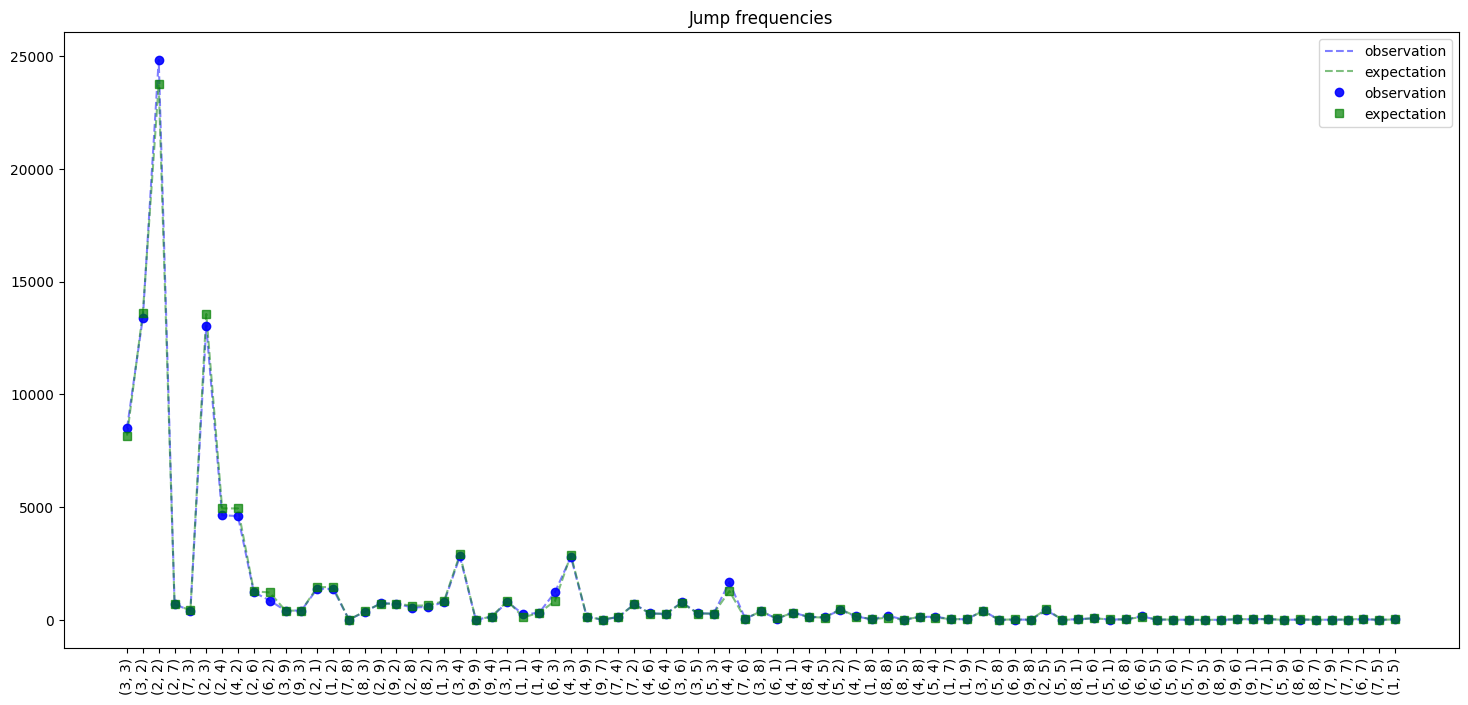

In [429]:

def goodness_of_fit(obs, exp):
    edge_freq_os = pd.merge(obs, exp, on = 'jump', how = 'inner')
    edge_freq_os.columns = ['jump', 'freq_obs', 'prob_obs', 'freq_exp',]
    edge_freq_os['diff'] = ((edge_freq_os['freq_obs'] - edge_freq_os['freq_exp'])**2)/edge_freq_os['freq_exp']
    
    gof = sum(edge_freq_os['diff'])
    x = np.linspace(0, 80, 81)
    plt.figure(figsize = (18,8))
    plt.plot(x, edge_freq_os.freq_obs, color = 'b', label = 'observation', linestyle = '--', alpha = 0.5)
    plt.plot(x, edge_freq_os.freq_exp, color = 'g', label = 'expectation', linestyle = '--', alpha = 0.5)
    plt.plot(x, edge_freq_os.freq_obs, color = 'b', marker = 'o', label = 'observation', linestyle = 'None', alpha = 0.9)
    plt.plot(x, edge_freq_os.freq_exp, color = 'g', marker = 's', label = 'expectation', linestyle = 'None', alpha = 0.7)
    plt.title('Jump frequencies')
    plt.legend()
    labels = edge_freq_os.jump.values
    plt.xticks(x, labels, rotation='vertical')
    
    return edge_freq_os, gof

df, gof = goodness_of_fit(obs_2step, exp_2step)
print(gof)
df

In [430]:
TM_ori

array([[0.12922465, 0.44168323, 0.24618953, 0.10636183, 0.01060305,
        0.02186879, 0.01822399, 0.01259112, 0.01325381],
       [0.02770013, 0.55051386, 0.26197432, 0.08955255, 0.00926841,
        0.02118493, 0.01345075, 0.01013009, 0.01620395],
       [0.02765721, 0.45363561, 0.35122144, 0.09186785, 0.01065394,
        0.02507443, 0.01226818, 0.01219643, 0.0154249 ],
       [0.03271073, 0.41507791, 0.2402013 , 0.23236233, 0.01316171,
        0.02487177, 0.01625859, 0.01248427, 0.01287138],
       [0.03543307, 0.42224409, 0.29035433, 0.14370079, 0.04429134,
        0.0246063 , 0.01279528, 0.01082677, 0.01574803],
       [0.01750547, 0.28628738, 0.36579139, 0.08679796, 0.00948213,
        0.17104303, 0.05032823, 0.00692925, 0.00583516],
       [0.0244898 , 0.43333333, 0.26122449, 0.09931973, 0.00680272,
        0.10340136, 0.05442177, 0.00884354, 0.00816327],
       [0.02234637, 0.3547486 , 0.23184358, 0.07681564, 0.00837989,
        0.01675978, 0.01326816, 0.2674581 , 0.00837989],


In [423]:
print("Goodness of fit: ", gof)
df[['jump', 'freq_obs', 'freq_exp']]

Goodness of fit:  861.7571554452551


,jump,freq_obs,freq_exp
0,"(3, 3)",8499,8178.090523
1,"(3, 2)",13405,13623.243634
2,"(2, 2)",24818,23746.194505
3,"(2, 7)",708,703.989391
4,"(7, 3)",423,431.200623
...,...,...,...
76,"(7, 9)",23,20.750251
77,"(7, 7)",28,28.735277
78,"(6, 7)",39,59.470073
79,"(7, 5)",14,14.974349


TypeError: not all arguments converted during string formatting

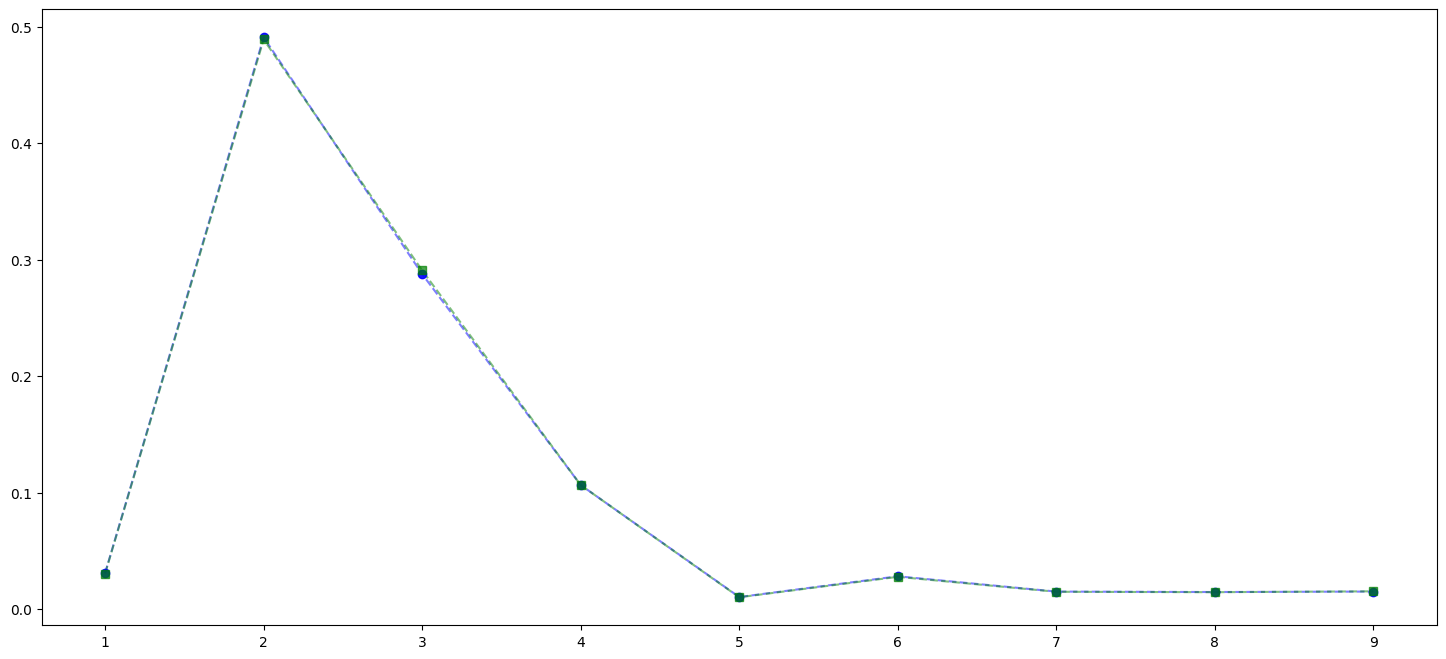

In [283]:
plt.figure(figsize = (18,8))

plt.plot(cc_freq.state, cc_freq.probability, color = 'b', linestyle = '--', label = 'observation', alpha = 0.5)
plt.plot(cc_freq_sim.state, cc_freq_sim.probability, color = 'g', linestyle = '--',label = 'expectation', alpha = 0.5)
plt.plot(cc_freq.state, cc_freq.probability, color = 'b', marker = 'o', linestyle = 'None', label = 'observation', alpha = 0.9)
plt.plot(cc_freq_sim.state, cc_freq_sim.probability, color = 'g', marker = 's', linestyle = 'None',label = 'expectation', alpha = 0.7)

for xy in zip(cc_freq.state, cc_freq.probability.round(3)): 
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data') 

plt.title('Probability distribution')
plt.legend()

In [282]:
cc_freq.probability.round(3)

3    0.031
0    0.491
1    0.288
2    0.107
8    0.010
4    0.028
6    0.015
7    0.015
5    0.015
Name: probability, dtype: float64

In [251]:
cc_freq_sim

,state,frequency,probability
3,1,2973,0.030668
0,2,47398,0.488932
1,3,28183,0.290720
2,4,10331,0.106569
8,5,996,0.010274
4,6,2697,0.027821
6,7,1453,0.014988
7,8,1419,0.014638
5,9,1492,0.015391
